# Assignment 2: Estimation of the potential using Random Walks

In this practice we are trying to find the electrostatic potential distribution inside of a square box, or
a more complicated geometry using random walks.

More specifically, we are trying to find the solution to a Laplace equation in two dimensions, since the
electrostatic potential inside an area bounded by a square box satisfies the Laplace equation
$$
    \frac{\partial^2\psi}{\partial x^2} + \frac{\partial^2\psi}{\partial y^2} = 0
$$
In absence of the boundary conditions the solution to the Laplace equation is given by a Gaussian distribution function.
This probability distribution also arises in a Random walk, thus we can reformulate the problem of finding the electrostatic
potential in a box as a random walk problem.

### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from tqdm import tqdm

### Class definition

We use a class as we need a way to keep track of multiple magnitudes for each point in the grid that makes the square box.
These are:
- The value of the potential.
- Which points in the grid are boundaries.
- The value of the gradient (which we calculate in the third section).
- A way to keep track of how many times we visit a specific point in the grid.

Then, we can initialise 4 different matrices of the same size that will keep track of each of these values.

On the other hand, we can define functions inside the class object so that we do not need to pass these matrices as arguments
all the time (so basically for convenience).

In [2]:
class Grid:
    def __init__(self,dim1,dim2):
        # The function that initialises the class object and generates
        # the 4 grids (or arrays).
        # Each grid point will keep track of:
        # - The value of the potential
        # - How many times we visit a certain position
        # - Whether the point is a boundary
        # - The value of the gradient
        self.potential = np.zeros((dim1+2,dim2+2))
        self.counts = np.zeros((dim1+2,dim2+2))
        self.boundaries = np.zeros((dim1+2,dim2+2),dtype=bool)
        self.gradient = np.zeros((dim1+2,dim2+2))
    
    def print_values(self,potential_plot_name='Ex2.1',plot_gradient=False,gradient_plot_name='Ex2.3'):
        # This function is only used to plot the potential and gradient
        [dim1,dim2] = self.potential.shape
        x = np.linspace(0,1,dim1)
        y = np.linspace(0,1,dim2)
        
        # Potential plot
        plt.pcolor(x[1:-2],y[1:-2],self.potential[1:-2,1:-2],cmap='gnuplot')
        plt.colorbar(location='right')
        plt.title(f'Potential in a {dim1-2}x{dim2-2} box')
        plt.savefig(f'{potential_plot_name}-{dim1-2}x{dim2-2}.png')
        plt.show()
        
        # Gradient plot
        if plot_gradient:
            plt.pcolor(x[1:-2],y[1:-2],self.gradient[1:-2,1:-2],cmap='gnuplot')
            plt.colorbar(location='right')
            plt.title(f'Gradient in a {dim1-2}x{dim2-2} box')
            plt.savefig(f'{gradient_plot_name}-{dim1-2}x{dim2-2}.png')
            plt.show()

    def set_boundaries(self,right,up,left,down):
        # This function sets the boundary conditions at
        # the edges of the grid (the borders of the box)
        self.potential[:,-1] = right
        self.potential[0,:] = up
        self.potential[:,0] = left
        self.potential[-1,:] = down

        # We need to set the boundary counts to 1 since
        # we are not exactly "visiting" these points during the random walks
        self.counts[:,-1] = 1
        self.counts[0,:] = 1
        self.counts[:,0] = 1
        self.counts[-1,:] = 1
        
        self.boundaries[:,-1] = True
        self.boundaries[0,:] = True
        self.boundaries[:,0] = True
        self.boundaries[-1,:] = True

    def set_bars(self,bar1,bar2,pos1=0.25,pos2=0.75,width=0.03,height=0.5):
        # This function sets the boundary conditions at two
        # bars inside the grid
        [dim1,dim2] = self.potential.shape
        
        # Calculate the dimensions of the two bars according to the given proportions
        bar_width = max(int(width*dim1),1)
        bar_height = int(height*dim1)
        start_index = int(dim2*pos1 - bar_width//2)
        end_index = int(dim2*pos2 - bar_width//2)
        
        # Set the values of the potential in the bars
        self.potential[(dim1-bar_height)//2:(dim1+bar_height)//2,start_index:start_index+bar_width] = bar1
        self.counts[(dim1-bar_height)//2:(dim1+bar_height)//2,start_index:start_index+bar_width] = 1
        self.boundaries[(dim1-bar_height)//2:(dim1+bar_height)//2,start_index:start_index+bar_width] = True
        self.potential[(dim1-bar_height)//2:(dim1+bar_height)//2,end_index:end_index+bar_width] = bar2
        self.counts[(dim1-bar_height)//2:(dim1+bar_height)//2,end_index:end_index+bar_width] = 1
        self.boundaries[(dim1-bar_height)//2:(dim1+bar_height)//2,end_index:end_index+bar_width] = True

    def random_walk(self,initial_pos,num_samples,maxIterations=100):
        # This is the loop that starts the random walks on a given initial position
        # It can be parallelized quite easily, but it is not necessary.
        for _ in range(num_samples):
            # Reset current coordinate to initial position and iteration count
            current_pos = dc(initial_pos)
            current_it = 0
            # We also reset the path of the random walk
            path = []

            # This while loop checks the boolean matrix for boundary points, and keeps iterating
            # until we visit one of them
            while (not self.boundaries[current_pos[0],current_pos[1]]) and current_it < maxIterations:
                # We add to the path the current position before modifying it and add one count to the
                # number of times we have visited the current position.
                path.append([current_pos[0],current_pos[1]])
                self.counts[current_pos[0],current_pos[1]] += 1
                # Toss one coin to decide direction, and another for the orientation, then
                # we modify the current position accordingly
                current_pos[np.random.binomial(1,0.5)] += 2*np.random.binomial(1,0.5)-1

            # Outside the loop, we checked if we reached a boundary point, if so,
            # we sum the value of the potential at the boundary to the entire path of the random walk
            if self.boundaries[current_pos[0],current_pos[1]]:
                # For each position in the random walk path
                for pos in range(len(path)):
                    x,y = path[pos]
                    self.potential[x,y] += self.potential[current_pos[0],current_pos[1]]
                    
    def calculate_potential(self,num_samples):
        # This function estimates the potential using random walks
        # across all points in the grid
        [dim1,dim2] = self.potential.shape
        for i in tqdm(range(dim1)):
            for j in range(dim2):
                if not self.boundaries[i,j]:
                    # We are iterating through every position in the grid
                    # and starting random walks on the points which are
                    # not boundaries
                    self.random_walk([i,j],num_samples)
        
        # At the end of all random walks, we need to divide the potential
        # inside the grid by the number of times we have visited each point
        self.potential /= self.counts
    
    def calculate_gradient(self):
        # This function estimates the gradient using its numerical
        # approximation
        [dim1,dim2] = self.gradient.shape
        # In this case the Δx corresponds to the width of the grid
        # (one position)
        h = 1
        for i in range(dim1-1):
            for j in range(dim2-1):
                # Normal potential term: V(x,y)
                potential = self.potential[i][j]
                # Displaced potential term: V(x+Δx,y)
                xpotential_plus = self.potential[i+1][j]
                # Displaced potential term: V(x,y+Δy)
                ypotential_plus = self.potential[i][j+1]
                # Numerical estimation of the (modulus of the) gradient
                self.gradient[i][j] = np.sqrt((xpotential_plus-potential)**2/(h**2) + (ypotential_plus-potential)**2/(h**2))


## Part 1: Potential estimation in a rectangular box
In this first part, we consider a rectangular box with boundary conditions at the edges:

    - Left: +10
    - Right: +1
    - Up: +1
    - Down: +1
We will estimate and plot the potential for a 30x30 grid.

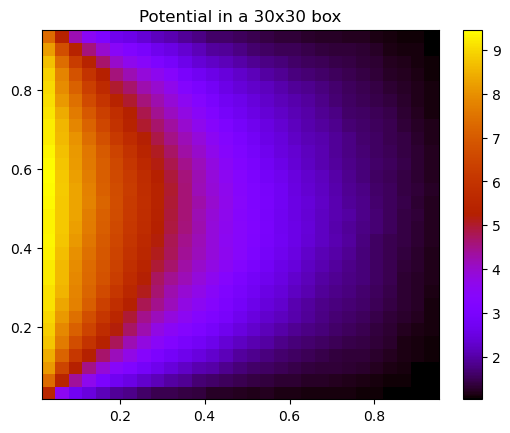

In [3]:
# Initialize the grid
grid = Grid(30,30)

# Set the boundary conditions: (right, up, left, down)
grid.set_boundaries(1,1,10,1)

# Calculate the potential
num_samples = 100
grid.calculate_potential(num_samples)

# Plot the results
grid.print_values()

## Part 2: Potential estimation of a plane condenser
For the second part, we will consider again a rectangular box, but the boundary conditions will now change to:

    - Potential at the edges: 0
    - Left vertical bar: +1
    - Right vertical bar: -1
The bars are positioned at approximately 0.25 and 0.75 inside the box horizontally and centered vertically.

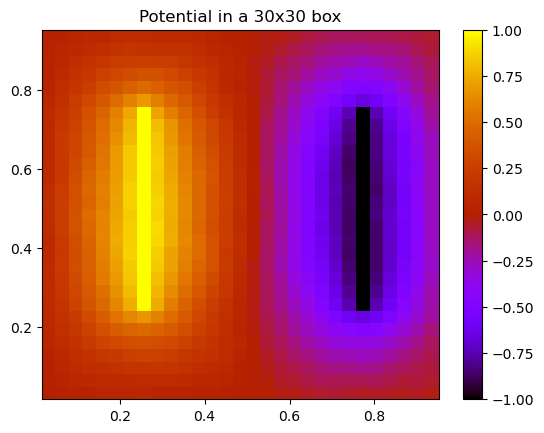

In [4]:
# Initialize the grid
grid = Grid(30,30)

# Set the boundary conditions: (right, up, left, down)
grid.set_boundaries(0,0,0,0)

# Set the boundary conditions for the bars: (left_bar, right_bar)
grid.set_bars(1,-1)

# Calculate the potential
num_samples = 100
grid.calculate_potential(num_samples)

# Plot the results
grid.print_values(potential_plot_name='Ex2.2')

## Part 3: Gradient estimation of a plane condenser
Finally, using the same example as in the previous part, we will estimate the gradient at each
point. For that we will use the following expression:

$$ 
    E = \sqrt{\left[\frac{V(x+\Delta x,y)-V(x,y)}{\Delta x}\right]^2 + \left[\frac{V(x,y+\Delta y)-V(x,y)}{\Delta y}\right]^2} = \sqrt{E^2_x+E^2_y}
$$

The width of the displacement should be very small compared to the size of the condenser. For that, we will use
a 100x100 grid (condenser ~50 units long x 3 units wide). We will also change the value of the potential at the bars to +10 and -10, and move
them a bit closer to each other, so that the gradient is larger between them.

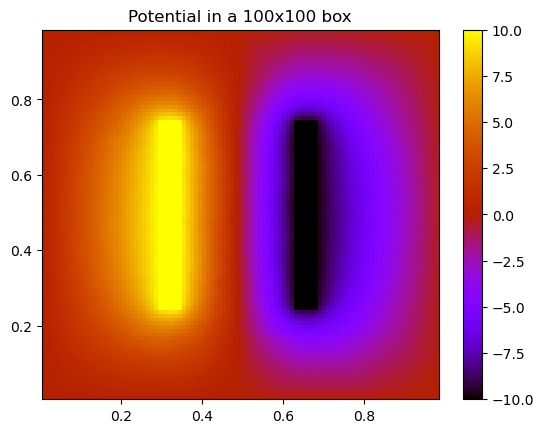

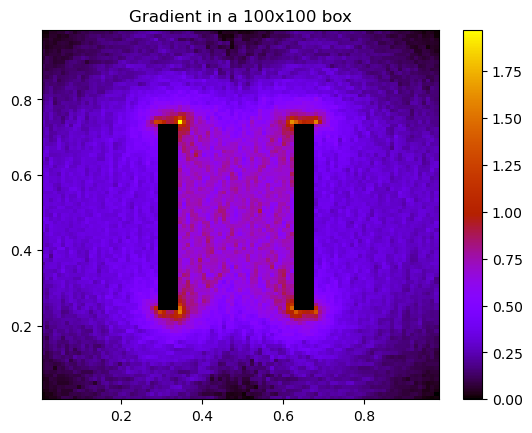

In [5]:
# Initialize the grid
grid = Grid(100,100)

# Set the boundary conditions: (right, up, left, down)
grid.set_boundaries(0,0,0,0)

# Set the boundary conditions for the bars: (left_bar, right_bar)
grid.set_bars(10,-10,pos1=0.33,pos2=0.66,width=0.06)

# Calculate the potential
num_samples = 100
grid.calculate_potential(num_samples)

# Calculate the gradient
grid.calculate_gradient()

# Plot the results
grid.print_values(potential_plot_name='Ex2.2',plot_gradient=True)